In [ ]:
!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

--2021-05-29 14:12:20--  https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68553005 (65M) [application/zip]
Saving to: ‘vehicles.zip’

vehicles.zip        100%[===================>]  65.38M  36.0MB/s    in 1.8s    

2021-05-29 14:12:22 (36.0 MB/s) - ‘vehicles.zip’ saved [68553005/68553005]

--2021-05-29 14:12:23--  https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57599296 (55M) [application/zip]
Saving to: ‘non-vehicles.zip’

non-vehicles.zip    100%[===================>]  54.93M  31.7MB/s    in 1.7s    

2021-05-29 14:12:25 (31.7 MB/s) - ‘non-vehicles.

In [ ]:
!unzip vehicles.zip
!unzip non-vehicles.zip

Streaming output truncated to the last 5000 lines.
  inflating: non-vehicles/Extras/extra5158.png  
  inflating: non-vehicles/Extras/extra5159.png  
  inflating: non-vehicles/Extras/extra516.png  
  inflating: non-vehicles/Extras/extra5160.png  
  inflating: non-vehicles/Extras/extra5161.png  
  inflating: non-vehicles/Extras/extra5162.png  
  inflating: non-vehicles/Extras/extra5163.png  
  inflating: non-vehicles/Extras/extra5164.png  
  inflating: non-vehicles/Extras/extra5165.png  
  inflating: non-vehicles/Extras/extra5166.png  
  inflating: non-vehicles/Extras/extra5167.png  
  inflating: non-vehicles/Extras/extra5168.png  
  inflating: non-vehicles/Extras/extra5169.png  
  inflating: non-vehicles/Extras/extra517.png  
  inflating: non-vehicles/Extras/extra5170.png  
  inflating: non-vehicles/Extras/extra5171.png  
  inflating: non-vehicles/Extras/extra5172.png  
  inflating: non-vehicles/Extras/extra5173.png  
  inflating: non-vehicles/Extras/extra5174.png  
  inflating: non-veh

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import os
from imutils.paths import list_images
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import cv2
from PIL import Image
import imgaug.augmenters as iaa

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
from torchsummary import summary
import glob

In [ ]:
from scipy.ndimage.measurements import label

In [ ]:
vehicle_paths = list(list_images('vehicles'))
non_vehicle_paths = list(list_images('non-vehicles'))

In [ ]:
cars = glob.glob("./vehicles/*/*.png")
non_cars = glob.glob("./non-vehicles/*/*.png")

In [ ]:
tmp1 = cv2.imread(vehicle_paths[0])
tmp2 = cv2.imread(non_vehicle_paths[0])

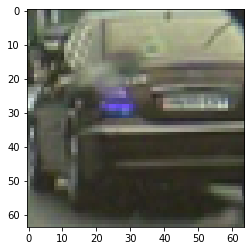

In [ ]:
plt.imshow(tmp1)

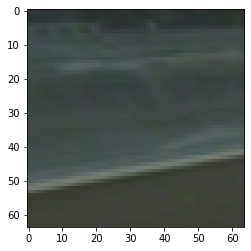

In [ ]:
plt.imshow(tmp2)

In [ ]:
print(f"Vehicle Images Length : {len(vehicle_paths)}")
print(f"Non Vehicle Images Length : {len(non_vehicle_paths)}")

Vehicle Images Length : 8792
Non Vehicle Images Length : 8968


In [ ]:
class data(Dataset):

  def __init__(self,img_paths,label,transforms=None):

    super().__init__()
    self.img_paths = img_paths
    self.transforms = transforms
    self.label = label
  
  def __getitem__(self,index):

    img = cv2.cvtColor(cv2.imread(self.img_paths[index]),cv2.COLOR_BGR2RGB)
    label = self.label[index]
    

    if self.transforms:
      img = self.transforms(img)
    
    return img,label
  
  def __len__(self):
    return len(self.img_paths)

In [ ]:
class augmentation():

  def __init__(self):
    self.transform = iaa.Sometimes(0.5,[iaa.OneOf([
                                iaa.Fliplr(1.0),
                                iaa.Affine(scale=(0.8,1.2)),
                                ])])
  def __call__(self,img):
    return Image.fromarray(self.transform(image=img)).convert('RGB')


In [ ]:
mean=0.5
std=0.5

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)])

In [ ]:
test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)])

In [ ]:
labels = np.concatenate( [ np.ones(len(vehicle_paths)), np.zeros(len(non_vehicle_paths)) ] )

In [ ]:
vehicle_paths.extend(non_vehicle_paths)

In [ ]:
len(vehicle_paths)

17760

In [ ]:
train_img,test_img,label_train,label_test = train_test_split(vehicle_paths,labels,test_size=0.1,random_state=42,stratify=labels)

In [ ]:
label_test.sum()/len(label_test)

0.49493243243243246

In [ ]:
label_train.sum()/len(label_train)

0.49505755755755754

In [ ]:
train_data = data(train_img,label_train,transform)
test_data = data(test_img,label_test,test_transform)

In [ ]:
train_loader = DataLoader(train_data,batch_size=128)
test_loader = DataLoader(test_data,batch_size=128,shuffle=False)

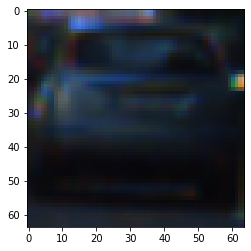

In [ ]:
plt.imshow(train_data[2][0].permute(1,2,0).numpy()*0.5+0.5)

In [ ]:
class Network(nn.Module):

  def __init__(self):

    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3,128,kernel_size=(3,3),stride=(1,1),padding=1,bias=False),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=1,bias=False),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=1,bias=False),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=1,bias=False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(8,8)),
        nn.Dropout(0.5),
    )

  
    

    self.fc = nn.Conv2d(128,1,kernel_size=(8,8))

    self.tanh = nn.Sigmoid()
  
  def forward(self,x):

    out = self.model(x)
    out = self.fc(out)
    out = self.tanh(out)

    return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Network().to(device)


In [ ]:
summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,456
              ReLU-2          [-1, 128, 64, 64]               0
           Dropout-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]         147,456
              ReLU-5          [-1, 128, 64, 64]               0
           Dropout-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]         147,456
              ReLU-8          [-1, 128, 64, 64]               0
           Dropout-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]         147,456
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
          Dropout-13            [-1, 128, 8, 8]               0
           Conv2d-14              [-1, 

In [ ]:
def calculate_accuracy(pred,true):

  pred = (pred >= 0.5).long()
  true = true.long()

  return (pred == true).sum().item()

In [ ]:
def train(model,loaders,opt,criterion,epoch,device):

  print(f"Epoch {epoch} ",end=" ")

  for name,loader in loaders:

    epoch_loss = []
    correct = 0
    total = 0

    if name == "test":
      model.eval()
    
    else :
      model.train()

    for img,label in loader:

      img = img.to(device)
      label = label.to(device).float()

      out = model(img).reshape(-1)
      
      loss = criterion(out,label)

      correct += calculate_accuracy(out,label)
      total += label.size(0)


      if name == "train":
        opt.zero_grad()
        loss.backward()
        opt.step()
      
      epoch_loss.append(loss.item())
    
    print(f"{name} Loss : {sum(epoch_loss)/len(epoch_loss)} Accuracy : {correct/total} ",end=" ")
  
  print(" ")





In [ ]:
epochs = 30
lr = 1e-4

In [ ]:
criterion = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(),lr=lr)

In [ ]:
loaders = [("train",train_loader),("test",test_loader)]

In [ ]:
for epoch in range(epochs):
  train(model,loaders,opt,criterion,epoch,device)

Epoch 0  train Loss : 0.5947871530055999 Accuracy : 0.6537162162162162  test Loss : 0.552013214145388 Accuracy : 0.768581081081081   
Epoch 1  train Loss : 0.37818004202842714 Accuracy : 0.8275775775775776  test Loss : 0.39220953413418363 Accuracy : 0.8158783783783784   
Epoch 2  train Loss : 0.23414304667711258 Accuracy : 0.9056556556556556  test Loss : 0.36795821147305624 Accuracy : 0.8220720720720721   
Epoch 3  train Loss : 0.16729065775871277 Accuracy : 0.9405655655655656  test Loss : 0.2985260539821216 Accuracy : 0.8530405405405406   
Epoch 4  train Loss : 0.13364632177352906 Accuracy : 0.9568318318318318  test Loss : 0.2695455721446446 Accuracy : 0.8755630630630631   
Epoch 5  train Loss : 0.11214837038516998 Accuracy : 0.9662787787787788  test Loss : 0.21157271840742656 Accuracy : 0.9009009009009009   
Epoch 6  train Loss : 0.09817801541090011 Accuracy : 0.970970970970971  test Loss : 0.17772839910217694 Accuracy : 0.9279279279279279   
Epoch 7  train Loss : 0.08963102647662163

In [ ]:
torch.save(model.state_dict(),"model.pth.tar")

In [ ]:
torch.save(opt.state_dict(),"opt.pth.tar")

In [ ]:
model.load_state_dict(torch.load("model.pth.tar"))

<All keys matched successfully>

In [ ]:
!git clone https://github.com/udacity/CarND-Vehicle-Detection.git

Cloning into 'CarND-Vehicle-Detection'...
remote: Enumerating objects: 65, done.
remote: Total 65 (delta 0), reused 0 (delta 0), pack-reused 65
Unpacking objects: 100% (65/65), done.


In [ ]:
test_img = cv2.cvtColor(cv2.imread("./CarND-Vehicle-Detection/test_images/test4.jpg"),cv2.COLOR_BGR2RGB)

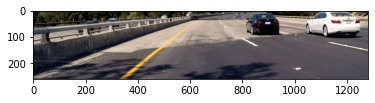

In [ ]:
plt.imshow(test_img[400:660,:,:])

In [ ]:
test_img = test_transform(Image.fromarray(test_img[400:660,:,:]))

In [ ]:
model.eval()

Network(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.5, inplace=False)
  )
  (fc): Conv2d(128, 1, kernel_size=(8, 8), stride=(1, 1))
  (tanh): Sigmoid()
)

In [ ]:
out = model(test_img.to(device).unsqueeze(0)).squeeze(0)

In [ ]:
out.shape

torch.Size([1, 25, 153])

In [ ]:
out = out.detach().cpu().numpy().reshape(25,153)

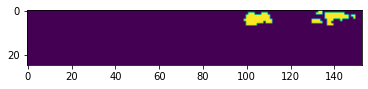

In [ ]:
plt.imshow(out>0.5)

In [ ]:
out = ( out > 0.5 ).astype('int')

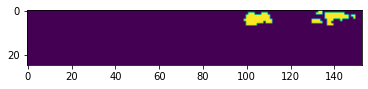

In [ ]:
plt.imshow(out)

In [ ]:
def search_cars(model,test_img_path,test_transform,device):

  test_img = Image.open(test_img_path).convert("RGB")

  test_img = test_transform(test_img).to(device).unsqueeze(0)
  test_img = test_img[:,:,400:660,:]
  out = model(test_img).squeeze(0).squeeze(0).detach().cpu().numpy()
  out = (out>0.5).astype('int')


  ratioH = out.shape[0]/test_img.shape[2]
  ratioW = out.shape[1]/test_img.shape[3]

  xx,yy = np.meshgrid(np.arange(out.shape[1]),np.arange(out.shape[0]))

  x = xx[out>0.99]
  y = yy[out>0.99]


  bboxes = []

  for i,j in zip(x,y):

    bboxes.append( ( (i/ratioW,400+j/ratioH), (i/ratioW+64,400+j/ratioH+64) ) )
  

  return bboxes



In [ ]:
def draw_bboxes(img,bboxes):

  img_c = img.copy()

  for p1,p2 in bboxes:
    p1 = (int(p1[0]),int(p1[1]))
    p2 = (int(p2[0]),int(p2[1]))

    cv2.rectangle(img_c,p1,p2,(0,255,0),3)
  
  return img_c

In [ ]:
bboxes = search_cars(model,"./CarND-Vehicle-Detection/test_images/test1.jpg",test_transform,device)

In [ ]:
img = cv2.cvtColor(cv2.imread("./CarND-Vehicle-Detection/test_images/test1.jpg"),cv2.COLOR_BGR2RGB)

In [ ]:
new_img = draw_bboxes(img,bboxes)

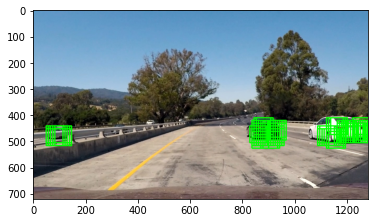

In [ ]:
plt.imshow(new_img)

In [ ]:
def add_heat(bboxes,h,w):

  heat_map = np.zeros((h,w))

  for p1,p2 in bboxes:

    p1 = ( int(p1[1]), int(p1[0]) )
    p2 = ( int(p2[1]), int(p2[0]) )

    heat_map[p1[0]:p2[0],p1[1]:p2[1]] += 1
  
  return heat_map



In [ ]:
heat_map = add_heat(bboxes,720,1280)

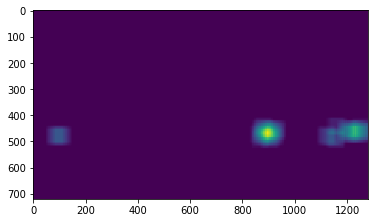

In [ ]:
plt.imshow(heat_map)

In [ ]:
def apply_threshold(heat_map,threshold):

  return ( heat_map >= threshold ).astype('int')

In [ ]:
threshold_heat_map = apply_threshold(heat_map,4)

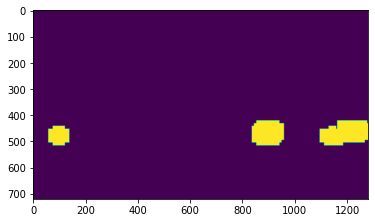

In [ ]:
plt.imshow(threshold_heat_map)

In [ ]:
labelled = label(threshold_heat_map)

In [ ]:
np.unique(labelled[0])

array([0, 1, 2, 3], dtype=int32)

In [ ]:
def draw_bounding_box(img,labels):

  img_c = img.copy()

  for c in range(1,labels[1]+1):

    yy,xx = (labels[0] == c).nonzero()
    
    p1 = (np.min(xx),np.min(yy))
    p2 = (np.max(xx),np.max(yy))
    print(p1,p2)

    cv2.rectangle(img_c,p1,p2,(0,255,0),5)
  
  return img_c

In [ ]:
img_f = draw_bounding_box(img,labelled)

(836, 420) (958, 515)
(1095, 420) (1279, 515)
(58, 441) (138, 515)


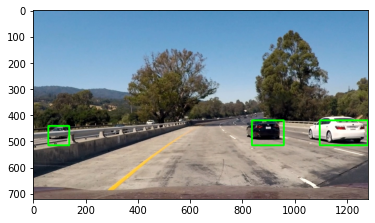

In [ ]:
plt.imshow(img_f)